In [84]:
import pandas as pd
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

Cargamos el archivo y comprobamos que los datos efectivamente están limpios

In [85]:
df = pd.read_csv('Train_recoded.csv')
df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
VIP             0
Name            0
Transported     0
Algun_Gasto     0
CabinDeck       0
CabinSide       0
Group           0
GroupNumber     0
Last Name       0
Solo            0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Gastos          0
CabinNumber     0
GroupSize       0
AgeGroup        0
dtype: int64

Recoficamos las variables categóricas en numéricas asignandoles valores numéricos en orden (0, 1, 2...)

In [87]:
df.loc[:, 'HomePlanet'] = df['HomePlanet'].map({'Europa': 0, 'Earth': 1, 'Mars': 2}).astype(int)
df.loc[:, 'CabinDeck'] = df['CabinDeck'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}).astype(int)
df.loc[:, 'CabinSide'] = df['CabinSide'].map({'P': 0, 'S': 1})
df.loc[:, 'CryoSleep'] = df['CryoSleep'].astype(int)
df.loc[:, 'Destination'] = df['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}).astype(int)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_11644\2690992866.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, 'CryoSleep'] = df['CryoSleep'].astype(int)


Separamos los conjuntos de entrenamiento y test, se eliminan además aquellas columnas que no vayan a usarse para el entrenamiento.

In [88]:
columnas_no_usadas = ["PassengerId", "Name", "Last Name", "Cabin"]

df = df.drop(columns = columnas_no_usadas)

y = df['Transported']
X = df.drop(['Transported'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [89]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.quniform('reg_alpha', 0, 10, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),  # Nuevo parámetro
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # Nuevo parámetro
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10)  # Nuevo parámetro
}

def objective(space):
    clf = xgb.XGBClassifier(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                gamma=space['gamma'],
                reg_alpha=int(space['reg_alpha']),
                reg_lambda=space['reg_lambda'],
                min_child_weight=int(space['min_child_weight']),
                colsample_bytree=space['colsample_bytree'],
                subsample=space['subsample'],
                learning_rate=space['learning_rate'],
                scale_pos_weight=space['scale_pos_weight'],
                eval_metric='logloss'
            )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    
    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,  # Número de evaluaciones que deseas hacer
                        trials=trials)

best_params = {
    'n_estimators': int(best_hyperparams['n_estimators']),
    'max_depth': int(best_hyperparams['max_depth']),
    'gamma': best_hyperparams['gamma'],
    'reg_alpha': int(best_hyperparams['reg_alpha']),
    'reg_lambda': best_hyperparams['reg_lambda'],
    'min_child_weight': int(best_hyperparams['min_child_weight']),
    'colsample_bytree': best_hyperparams['colsample_bytree'],
    'subsample': best_hyperparams['subsample'],
    'learning_rate': best_hyperparams['learning_rate'],
    'scale_pos_weight': best_hyperparams['scale_pos_weight'],
    'eval_metric': 'logloss'
}

clf = xgb.XGBClassifier(**best_params)

clf.fit(X_train, y_train, eval_set= eval_set, verbose = False)

100%|██████████| 100/100 [00:39<00:00,  2.52trial/s, best loss: -0.8004997917534361]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.998641174292206, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.499981317571927, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17062887395241755,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=123, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Sacamos los resultados de accuracy, validación cruzada y pintamos los gráficos de curva roc y matriz de confusión

In [90]:
results = clf.evals_result()

y_pred = clf.predict(X_test)

cv_scores = cross_val_score(clf, X, y, cv=5)

print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

Puntajes de validación cruzada: [0.60337289 0.685625   0.7125     0.750625   0.7625    ]
Media de los puntajes: 0.7029245783885072


Precisión del modelo: 0.8004997917534361


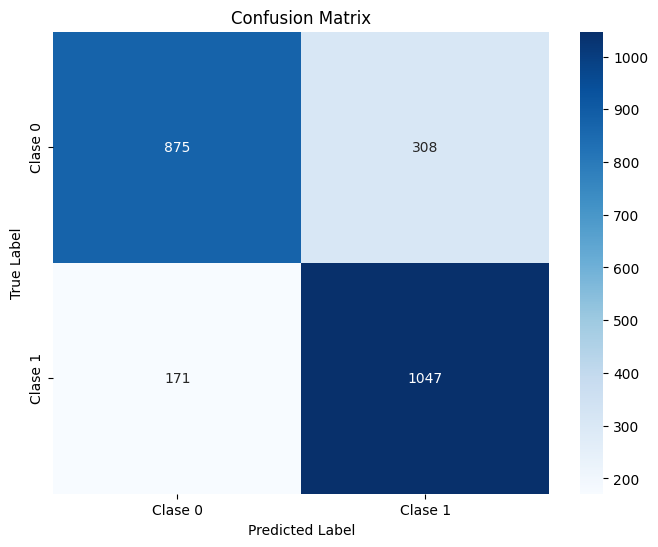

Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.84      0.74      0.79      1183
        True       0.77      0.86      0.81      1218

    accuracy                           0.80      2401
   macro avg       0.80      0.80      0.80      2401
weighted avg       0.80      0.80      0.80      2401



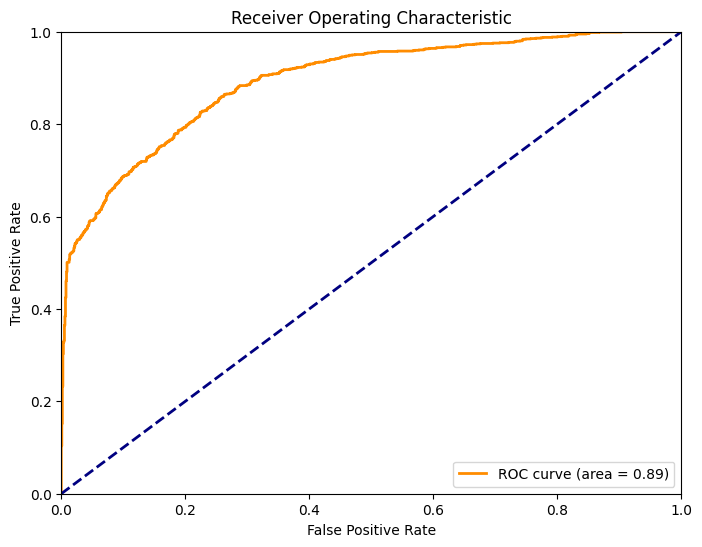

In [91]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Podemos hacer también un análisis de las features que hemos incluido en el modelo para comprobar si puede suprimirse alguna que no aporte al modelo.

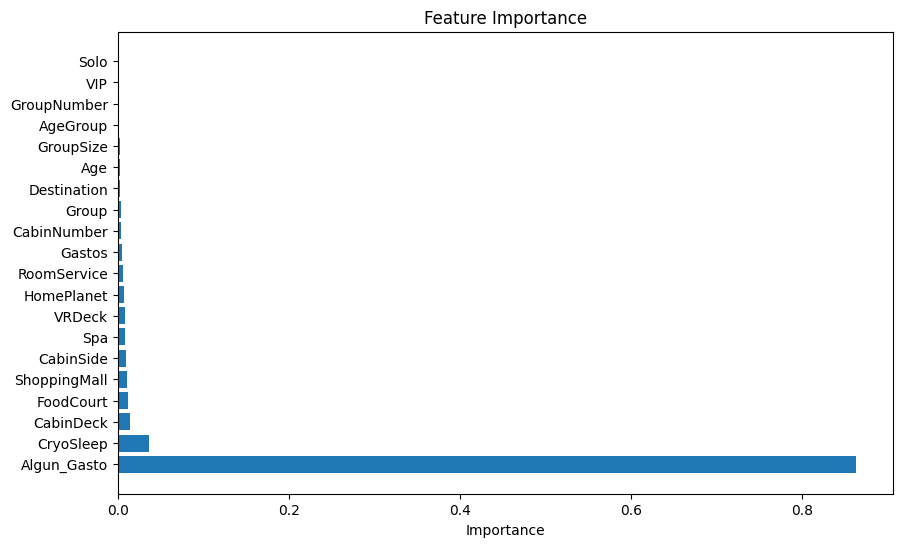

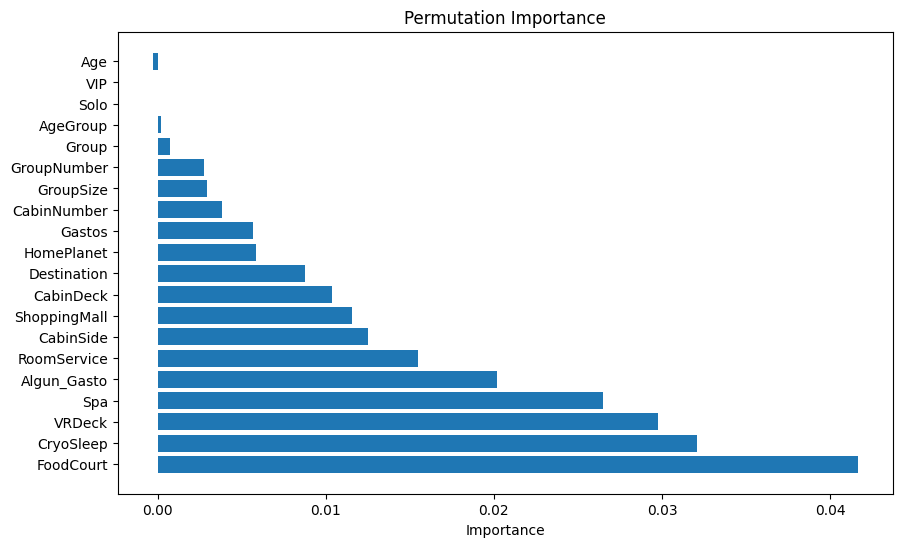

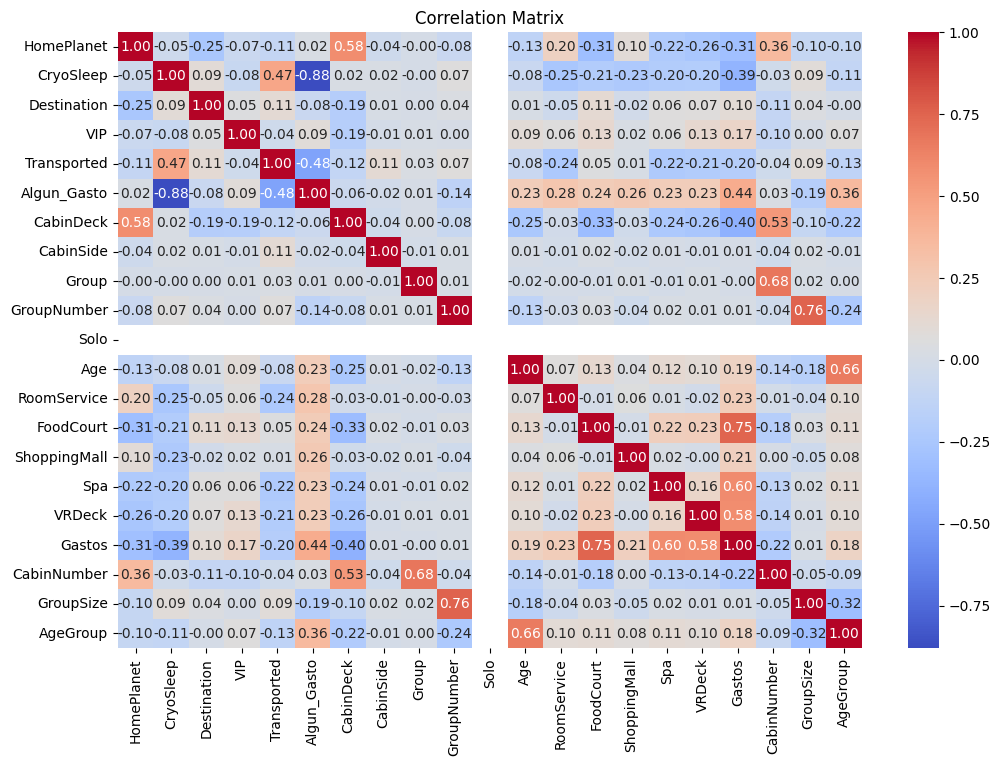

In [92]:
importances = clf.feature_importances_

# Crear un DataFrame para facilitar la visualización
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

from sklearn.inspection import permutation_importance

# Obtener la importancia por permutación
result = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)

# Crear un DataFrame con los resultados
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Graficar la importancia por permutación
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Permutation Importance')
plt.show()

correlation_matrix = df.corr()

# Graficar el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Parece que la variable de Solo no esta aportando nada al modelo, y se podría valorar también la exclusión de la variable VIP. Reentrenamos el modelo con esas condiciones.

In [93]:
features_eliminadas = ['Solo', 'VIP']

y = df['Transported']
X = df.drop(features_eliminadas + ['Transported'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [94]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.quniform('reg_alpha', 0, 10, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),  # Nuevo parámetro
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # Nuevo parámetro
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10)  # Nuevo parámetro
}

def objective(space):
    clf = xgb.XGBClassifier(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                gamma=space['gamma'],
                reg_alpha=int(space['reg_alpha']),
                reg_lambda=space['reg_lambda'],
                min_child_weight=int(space['min_child_weight']),
                colsample_bytree=space['colsample_bytree'],
                subsample=space['subsample'],
                learning_rate=space['learning_rate'],
                scale_pos_weight=space['scale_pos_weight'],
                eval_metric='logloss'
            )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    
    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,  # Número de evaluaciones que deseas hacer
                        trials=trials)

best_params = {
    'n_estimators': int(best_hyperparams['n_estimators']),
    'max_depth': int(best_hyperparams['max_depth']),
    'gamma': best_hyperparams['gamma'],
    'reg_alpha': int(best_hyperparams['reg_alpha']),
    'reg_lambda': best_hyperparams['reg_lambda'],
    'min_child_weight': int(best_hyperparams['min_child_weight']),
    'colsample_bytree': best_hyperparams['colsample_bytree'],
    'subsample': best_hyperparams['subsample'],
    'learning_rate': best_hyperparams['learning_rate'],
    'scale_pos_weight': best_hyperparams['scale_pos_weight'],
    'eval_metric': 'logloss'
}

clf = xgb.XGBClassifier(**best_params)

clf.fit(X_train, y_train, eval_set= eval_set, verbose = False)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:46<00:00,  2.14trial/s, best loss: -0.8071636817992504]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7925513105147479, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=1.652428132378363, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.22739453088271755,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=181, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [95]:
results = clf.evals_result()

y_pred = clf.predict(X_test)

cv_scores = cross_val_score(clf, X, y, cv=5)

print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

Puntajes de validación cruzada: [0.64834478 0.6975     0.73375    0.780625   0.733125  ]
Media de los puntajes: 0.7186689569019362


Precisión del modelo: 0.8071636817992504


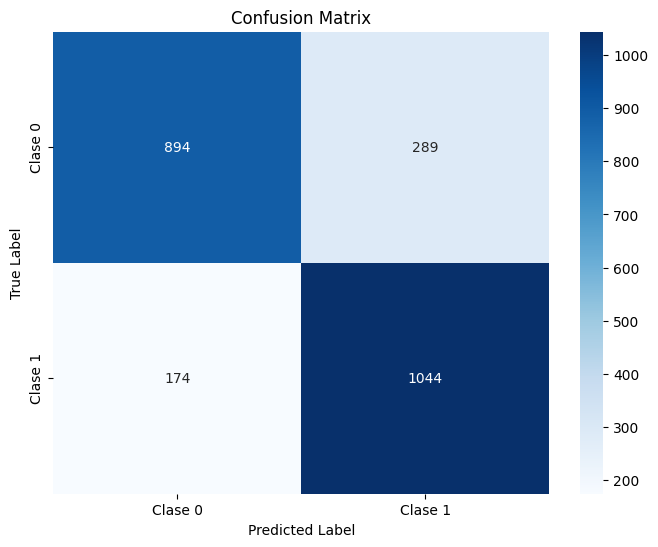

Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.84      0.76      0.79      1183
        True       0.78      0.86      0.82      1218

    accuracy                           0.81      2401
   macro avg       0.81      0.81      0.81      2401
weighted avg       0.81      0.81      0.81      2401



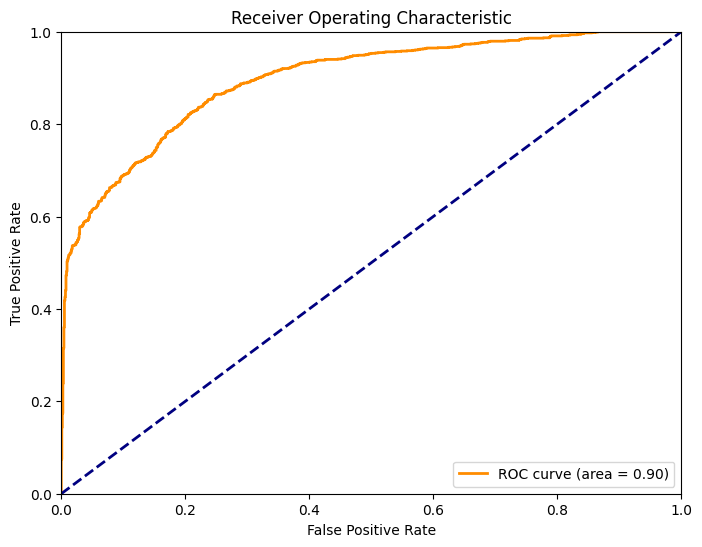

In [96]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

El ajuste parece mejor pero no mejora mucho la precisión del modelo. Podemos seguir valorando la exclusión de alguna variable pero probablemente solo consigamos bajar la precisión.

Una vez entrenado podemos aplicar el modelo a los datos

In [97]:
df_t = pd.read_csv('Test_recoded.csv')

df_test = df_t.drop(columns = ['Transported'] + columnas_no_usadas + features_eliminadas)

df_test.loc[:, 'HomePlanet'] = df_test['HomePlanet'].map({'Europa': 0, 'Earth': 1, 'Mars': 2}).astype(int)
df_test.loc[:, 'CabinDeck'] = df_test['CabinDeck'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}).astype(int)
df_test.loc[:, 'CabinSide'] = df_test['CabinSide'].map({'P': 0, 'S': 1}).astype(int)
df_test.loc[:, 'CryoSleep'] = df_test['CryoSleep'].astype(int)
df_test.loc[:, 'Destination'] = df_test['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}).astype(int)

df_test = df_test.astype(int)

prediccion = clf.predict(df_test)

df_predict = pd.DataFrame({
    'PassengerId': df_t['PassengerId'],
    'Transported': prediccion.astype(bool)
})

df_predict.to_csv('prediccion_xgb_base.csv', index = False)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_11644\1684751711.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 1 ... 1 0 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_test.loc[:, 'CryoSleep'] = df_test['CryoSleep'].astype(int)
